# 01 — DP baseline (punkt odniesienia) na FrozenLake

**Dlaczego to robimy?**  
DP to „złoty standard” *gdy znasz model* $P(s'|s,a)$.  
W kolejnych notebookach zabierzemy model (model-free) i zobaczymy, jak MC/TD dochodzą do podobnych wartości tylko z próbek.
Tutaj chodzi głównie o częściowe przypomnienie i poukładanie wiedzy.

> FrozenLake z `is_slippery=True` jest odpowiedni, bo DP liczy oczekiwania po rozkładzie przejść, a MC/TD muszą to „wybadać”.


In [36]:
import os, sys
# dodaj katalog główny repo do ścieżki importów
REPO_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if REPO_ROOT not in sys.path:
    sys.path.insert(0, REPO_ROOT)

import numpy as np
import matplotlib.pyplot as plt

In [37]:
from envs.frozenlake import FROZENLAKE_MAPS, build_frozenlake_P, find_start_state, PModelEnv
from envs.wrappers import get_spec
from algorithms.dp import policy_evaluation, value_iteration, greedy_policy_from_V
from algorithms.utils import plot_value_heatmap

## Wybór wariantu FrozenLake

- `SLIPPERY=False` → środowisko deterministyczne (łatwe)
- `SLIPPERY=True` → probabilistyczne (didaktycznie lepsze)


In [38]:
SLIPPERY = True
MAP_NAME = "4x4"
SEED = 0
GAMMA = 0.99

# TODO: zmień mapę na "8x8" albo podaj własną listę stringów.
desc = FROZENLAKE_MAPS[MAP_NAME]

# Budujemy jawny model P[s][a] w czystym Pythonie (jak w Ch04/Ch05).
P, nS, nA, nrow, ncol, desc_arr = build_frozenlake_P(desc, is_slippery=SLIPPERY)

# Start state (S) – dokładnie to samo ćwiczyliśmy w Ch05_00.
s0 = find_start_state(desc_arr)

# (Opcjonalnie) Tworzymy env tylko po to, żeby mieć spójny spec i wizualizację.
# DP poniżej korzysta bezpośrednio z P.
env = PModelEnv(P, start_state=s0, seed=SEED, desc=desc_arr)
env.nrow, env.ncol, env.desc = nrow, ncol, desc_arr  # pomocnicze atrybuty
spec = get_spec(env, gamma=GAMMA)

print("Mapa FrozenLake:")
print("\n".join("".join(row) for row in desc_arr))
print(f"MAP_NAME={MAP_NAME}  SLIPPERY={SLIPPERY}  s0={s0}  gamma={GAMMA}")
spec


Mapa FrozenLake:
SFFF
FHFH
FFFH
HFFG
MAP_NAME=4x4  SLIPPERY=True  s0=0  gamma=0.99


DiscreteEnvSpec(nS=16, nA=4, shape=(4, 4), terminals={5, 7, 11, 12, 15}, gamma=0.99, desc=array([['S', 'F', 'F', 'F'],
       ['F', 'H', 'F', 'H'],
       ['F', 'F', 'F', 'H'],
       ['H', 'F', 'F', 'G']], dtype='<U1'))

## 1) Ewaluacja losowej polityki

Poniżej pokazujemy, że DP potrafi policzyć $V^\pi$ „od razu”, bo zna $P$.  
Potem MC/TD będą robiły to samo, ale **próbkując epizody**.


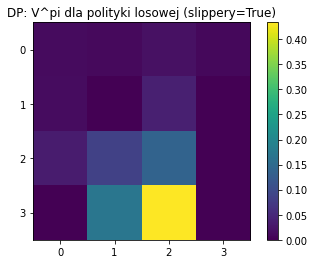

Bellman check s0=0: V_pi[s0]=0.012356, RHS=0.012356, diff=+5.94e-11


In [39]:
# Policy evaluation (DP) realizuje równanie Bellmana dla ustalonej
# polityki π:
#
#   V^π(s) = Σ_a π(a|s) Σ_{s'} P(s'|s,a) [ R(s,a,s') + γ V^π(s') ]
#
# W implementacji iteracyjnej robimy tzw. Bellman backup:
#
#   V_{k+1}(s) ← Σ_a π(a|s) Σ_{s'} P(s'|s,a) [ r + γ V_k(s') ]
#
# i powtarzamy aż zmiana max_s |V_{k+1}(s) - V_k(s)| < θ.


# losowa polityka: pi(a|s)=1/nA
pi_random = np.ones((spec.nS, spec.nA), dtype=np.float64) / spec.nA
V_pi = policy_evaluation(P, pi_random, gamma=spec.gamma)
plot_value_heatmap(V_pi, spec.shape, title=f"DP: V^pi dla polityki losowej (slippery={SLIPPERY})")

# --- mini-check: Bellman equation dla V^pi (na stanie startowym) ---
# To jest dokładnie to samo sumowanie po outcomes, które widzieliśmy w 00 w P[s][a] 
# oraz na poprzednich zajęciach
s = int(s0)
rhs = 0.0
for a, p_a in enumerate(pi_random[s]):
    if p_a == 0:
        continue
    for prob, sp, r, done in P[s][a]:
        rhs += p_a * prob * (r + (0.0 if done else spec.gamma * V_pi[sp]))

print(f"Bellman check s0={s}: V_pi[s0]={V_pi[s]:.6f}, RHS={rhs:.6f}, diff={rhs - V_pi[s]:+.2e}")


### Co oznacza wynik policy evaluation?

W tej części liczymy wartość stanu $V^\pi(s)$ dla **ustalonej polityki** $\pi$ (np. losowej).  
Dynamic Programming może to zrobić, bo mamy jawny model przejść $P(s'|s,a)$.

Policy evaluation znajduje $V^\pi$ spełniające równanie Bellmana:

$$
V^\pi(s) = \sum_a \pi(a|s)\sum_{s'} P(s'|s,a)\Big[r(s,a,s') + \gamma V^\pi(s')\Big].
$$

Intuicyjnie: wartość stanu to **oczekiwana suma zd


## 2) Value Iteration → $V^*$ (optymalne)

Wartość optymalna jest dobrym „targetem” do porównań (np. MSE dla MC/TD).


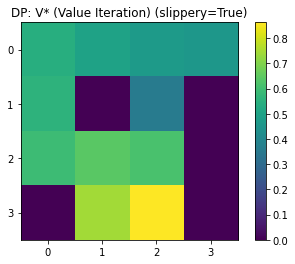

Porównanie na starcie s0=0:  V^pi_random=0.012356   V*=0.542026


In [40]:
V_star = value_iteration(P, gamma=spec.gamma)
plot_value_heatmap(V_star, spec.shape, title=f"DP: V* (Value Iteration) (slippery={SLIPPERY})")

pi_star = greedy_policy_from_V(P, V_star, gamma=spec.gamma)
# pi_star to rozkład, ale w praktyce można wziąć argmax

print(f"Porównanie na starcie s0={int(s0)}:  V^pi_random={V_pi[int(s0)]:.6f}   V*={V_star[int(s0)]:.6f}")


## Ćwiczenia (na zajęcia)

1. Porównaj mapy dla `SLIPPERY=False` i `SLIPPERY=True`. Co się zmienia i dlaczego?  
2. Zmień $\gamma$ na 0.9 i 0.99. Jak to wpływa na „rozlanie” wartości?  
3. (Dyskusja) Czemu DP jest mało użyteczne w dużych światach / realnych problemach?


# DEMONSTRACJE

# Nie trzeba wykonywać - demontracyjnie - pozane heatmapy snapshotów policy evaluation.

Zapisane iteracje: [0, 1, 2, 5, 10, 20, 50, 100]
Ostatnia delta: 8.571286042036164e-13


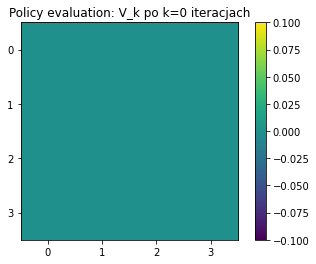

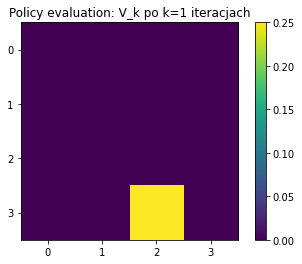

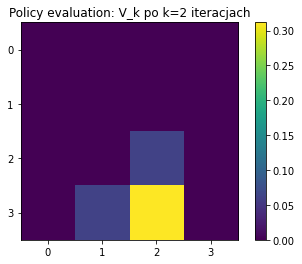

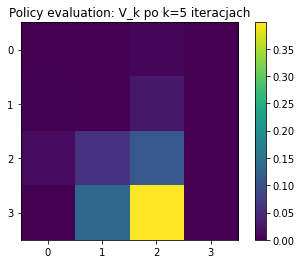

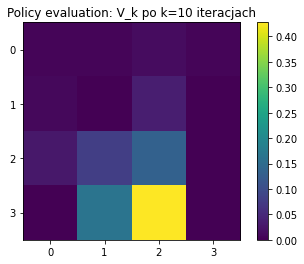

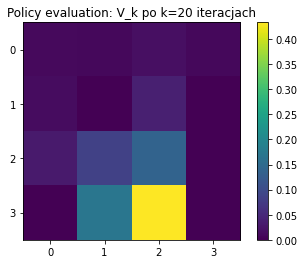

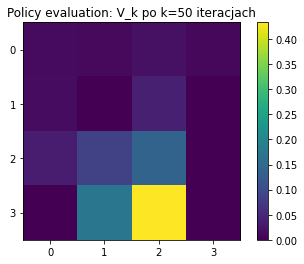

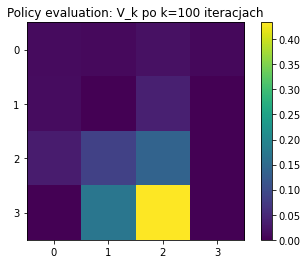

In [41]:
# ============================================================
# Policy evaluation: snapshoty V_k i heatmapy zbieżności
# ============================================================
# Not TODO: Zmień iters_to_save i zobacz, jak szybko "rozlewa się" wartość.
# Not TODO: Porównaj SLIPPERY=False vs SLIPPERY=True.
# Not TODO: Zmień gamma (np. 0.90 vs 0.99) i zobacz wpływ na skalę wartości.

import numpy as np

def policy_evaluation_snapshots(P, pi, gamma=0.99, max_iter=500, iters_to_save=(0,1,2,5,10,20,50,100), theta=1e-12):
    """
    Iteracyjne policy evaluation: V_{k+1} = T^π V_k.
    Zwraca:
      - snapshots: dict {k: V_k} dla wybranych iteracji k
      - deltas: lista delta_k = max_s |V_{k+1}(s) - V_k(s)|
    """
    nS = len(P)
    V = np.zeros(nS, dtype=np.float64)

    iters_to_save = set(iters_to_save)
    snapshots = {}
    deltas = []

    # snapshot dla k=0 (start)
    if 0 in iters_to_save:
        snapshots[0] = V.copy()

    for k in range(1, max_iter + 1):
        V_new = np.zeros_like(V)
        delta = 0.0

        for s in range(nS):
            v = 0.0
            for a, p_a in enumerate(pi[s]):
                if p_a == 0:
                    continue
                for prob, sp, r, done in P[s][a]:
                    v += p_a * prob * (r + (0.0 if done else gamma * V[sp]))
            V_new[s] = v
            delta = max(delta, abs(V_new[s] - V[s]))

        V = V_new
        deltas.append(delta)

        if k in iters_to_save:
            snapshots[k] = V.copy()

        if delta < theta:
            # jeśli zbiegnie wcześniej, też zapisujemy ostatni stan (jeśli ktoś chce)
            break

    return snapshots, deltas

# --- użycie: zakładam, że masz już P, spec, pi_random, spec.gamma ---
iters_to_save = (0, 1, 2, 5, 10, 20, 50, 100)
snapshots, deltas = policy_evaluation_snapshots(P, pi_random, gamma=spec.gamma, max_iter=500, iters_to_save=iters_to_save)

print("Zapisane iteracje:", sorted(snapshots.keys()))
print("Ostatnia delta:", deltas[-1] if deltas else None)

# --- heatmapy V_k ---
for k in sorted(snapshots.keys()):
    V_k = snapshots[k]
    plot_value_heatmap(V_k, spec.shape, title=f"Policy evaluation: V_k po k={k} iteracjach")


## Porównanie polityki losowej i greedy

[random] last delta = 8.571286042036164e-13
[greedy(V*)] last delta = 1.2619055800300316e-09
s0=0:  V^random(s0)=0.012356   V^greedy(V*)(s0)=0.520260   V*(s0)=0.522281


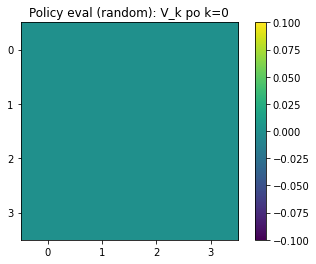

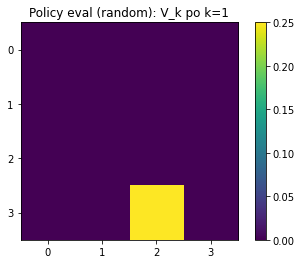

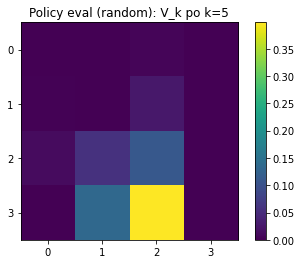

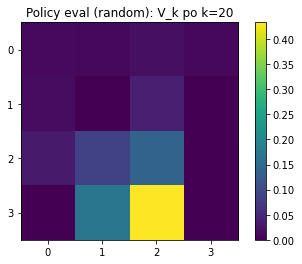

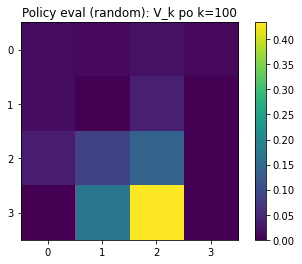

In [45]:
# ============================================================
# Policy evaluation: porównanie dwóch polityk π (random vs greedy z V*)
# ============================================================

# --- 1) polityka losowa ---
pi1_name = "random"
pi1 = pi_random

# --- 2) polityka greedy z V* (czyli π(s)=argmax_a Σ P[r+γV*]) ---
# Uwaga: greedy_policy_from_V zwraca rozkład (często deterministyczny one-hot).
pi2_name = "greedy(V*)"
pi2 = greedy_policy_from_V(P, V_star, gamma=spec.gamma)

iters_to_save = (0, 1, 2, 5, 10, 20, 50, 100)

snap1, del1 = policy_evaluation_snapshots(P, pi1, gamma=spec.gamma, max_iter=500, iters_to_save=iters_to_save)
snap2, del2 = policy_evaluation_snapshots(P, pi2, gamma=spec.gamma, max_iter=500, iters_to_save=iters_to_save)

print(f"[{pi1_name}] last delta = {del1[-1] if del1 else None}")
print(f"[{pi2_name}] last delta = {del2[-1] if del2 else None}")

s0i = int(s0)
k_last_1 = max(snap1.keys())
k_last_2 = max(snap2.keys())
print(f"s0={s0i}:  V^{pi1_name}(s0)={snap1[k_last_1][s0i]:.6f}   V^{pi2_name}(s0)={snap2[k_last_2][s0i]:.6f}   V*(s0)={V_star[s0i]:.6f}")

# --- heatmapy: pokazujemy tylko kilka iteracji, żeby nie zalać notebooka ---
show_ks = (0, 1, 5, 20, 100)
show_ks = [k for k in show_ks if k in snap1 and k in snap2]

for k in show_ks:
    #TODO od komentować ewaluację jednej i drugiej polityki - random/greedy
    plot_value_heatmap(snap1[k], spec.shape, title=f"Policy eval ({pi1_name}): V_k po k={k}")
    #plot_value_heatmap(snap2[k], spec.shape, title=f"Policy eval ({pi2_name}): V_k po k={k}")



# Optymalizacja problemu Value iteration 

Zapisane iteracje: [0, 1, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
Ostatnia delta: 1.142802075193572e-09


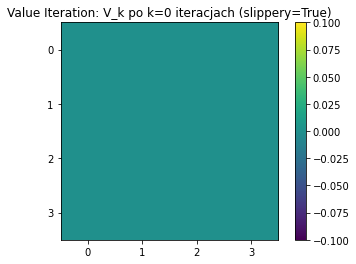

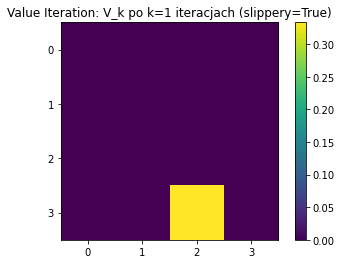

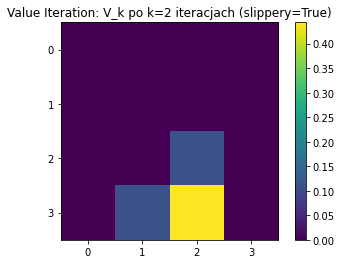

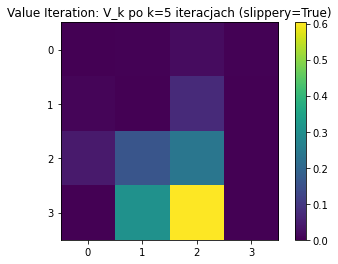

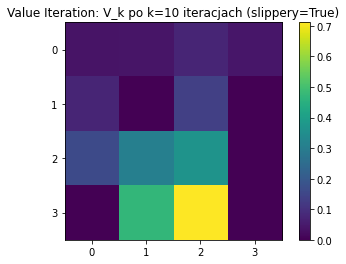

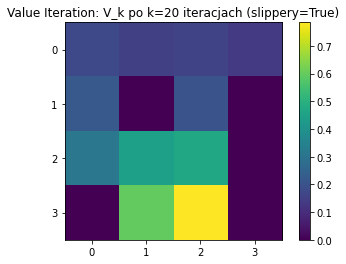

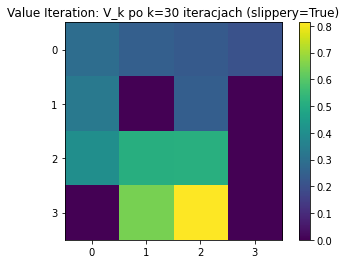

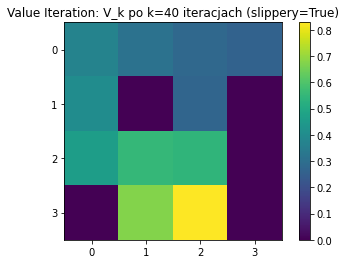

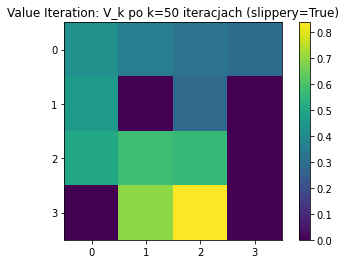

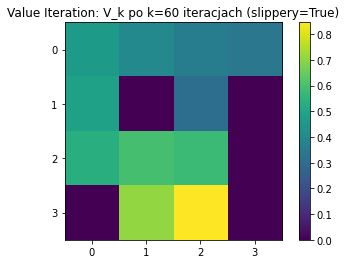

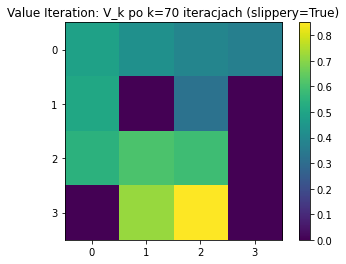

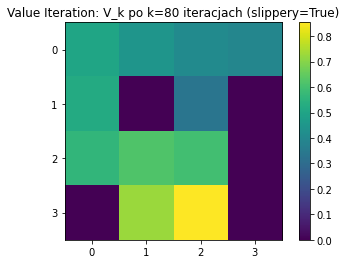

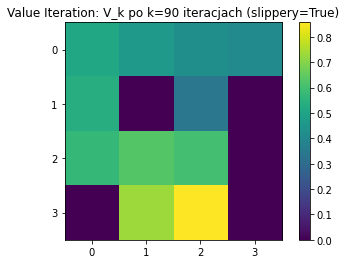

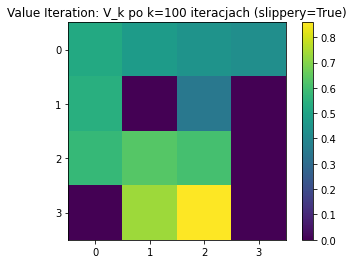

In [44]:
# ============================================================
# Value Iteration: snapshoty V_k i heatmapy zbieżności do V*
# ============================================================
# Not TODO: Zmień iters_to_save i zobacz jak szybko zbiega do V*.
# Not TODO: Porównaj SLIPPERY=False vs SLIPPERY=True.
# Not TODO: Zmień gamma (np. 0.90 vs 0.99) i zobacz wpływ na wartości.

import numpy as np

def value_iteration_snapshots(P, gamma=0.99, max_iter=500, iters_to_save=(0,1,2,5,10,20,50,100), theta=1e-12):
    """
    Value iteration: V_{k+1}(s) = max_a Σ_{s'} P(s'|s,a)[ r + γ V_k(s') ].
    Zwraca snapshots {k: V_k} oraz deltas (max zmiana na iterację).
    """
    nS = len(P)
    V = np.zeros(nS, dtype=np.float64)

    iters_to_save = set(iters_to_save)
    snapshots = {}
    deltas = []

    if 0 in iters_to_save:
        snapshots[0] = V.copy()

    for k in range(1, max_iter + 1):
        V_new = np.zeros_like(V)
        delta = 0.0

        for s in range(nS):
            best = -1e18
            for a in range(len(P[s])):  # nA
                q = 0.0
                for prob, sp, r, done in P[s][a]:
                    q += prob * (r + (0.0 if done else gamma * V[sp]))
                if q > best:
                    best = q
            V_new[s] = best
            delta = max(delta, abs(V_new[s] - V[s]))

        V = V_new
        deltas.append(delta)

        if k in iters_to_save:
            snapshots[k] = V.copy()

        if delta < theta:
            break

    return snapshots, deltas

iters_to_save = (0, 1, 2, 5, 10, 20,30,40 ,50,60,70,80,90, 100)
snapshots_vi, deltas_vi = value_iteration_snapshots(P, gamma=spec.gamma, max_iter=500, iters_to_save=iters_to_save)

print("Zapisane iteracje:", sorted(snapshots_vi.keys()))
print("Ostatnia delta:", deltas_vi[-1] if deltas_vi else None)

for k in sorted(snapshots_vi.keys()):
    V_k = snapshots_vi[k]
    plot_value_heatmap(V_k, spec.shape, title=f"Value Iteration: V_k po k={k} iteracjach (slippery={SLIPPERY})")

V_star_snap = snapshots_vi[max(snapshots_vi.keys())]  # ostatni zapisany


## Przejście: z DP (model-based) do MC/TD (model-free)

W **DP** zakładaliśmy, że znamy model środowiska $P[s][a]$ i dlatego mogliśmy liczyć wartości przez sumowanie po wszystkich możliwych wynikach kroku (wartość oczekiwana).

Od teraz przechodzimy do metod **model-free**, gdzie zakładamy, że **nie znamy $P$** i mamy tylko generator doświadczeń `step()`.

- **Monte Carlo (MC)** uczy się z pełnych epizodów i używa zwrotu:
  $$G_t = r_{t+1} + \gamma r_{t+2} + \gamma^2 r_{t+3} + \dots$$
  MC **nie robi bootstrappingu**: nie podstawia własnych przewidywań $V(s')$.

- **Temporal Difference (TD)** aktualizuje „w trakcie” i używa targetu 1-krokowego:
  $$r_{t+1} + \gamma V(s_{t+1}).$$

W kolejnych notebookach będziemy czasem liczyć DP-baseline tylko po to, by mieć „prawdę” do porównań (np. MSE), ale **sam proces uczenia w MC/TD będzie oparty wyłącznie o trajektorie z `step()`**.
